<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Transduction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 4.2 MB/s eta 0:00:00
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp38-cp38-linux_x86_64.whl size=1895969 sha256=ea86b22cb4b917cadb3976f28c38f28ca17e38633e47adeb42854a409450e22f
  Stored in directory: /root/.cache/pip/wheels/ce/f3/d8/389d390e98d568ea1dbcbd36398e73360038c289d29e78c462
  Created wheel for future: filename=future-0

In [2]:
import numpy as np
import pandas as pd
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/1f6m43e1q5ix59n/AACoAxJRj1N-YAEOSXdOx8wIa?dl=0', 'images')
file_list = get_sub_files(folder)
file_list.sort()

--2023-03-03 23:33:20--  https://www.dropbox.com/sh/1f6m43e1q5ix59n/AACoAxJRj1N-YAEOSXdOx8wIa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/1f6m43e1q5ix59n/AACoAxJRj1N-YAEOSXdOx8wIa [following]
--2023-03-03 23:33:21--  https://www.dropbox.com/sh/raw/1f6m43e1q5ix59n/AACoAxJRj1N-YAEOSXdOx8wIa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb8e47201ad32508ea6336dfeb1.dl.dropboxusercontent.com/zip_download_get/Ba9NTlK3P8dkvF1dUTeEH_NSYIxjWaMKoRJeFP4l6GJtl0bQkZbpnXLa0YfvooBagQPOJrgoxiCN6GxWeMPKzj7OfjPuf12l6vmbqEz0VDcfow# [following]
--2023-03-03 23:33:22--  https://ucb8e47201ad32508ea6336dfeb1.dl.dropboxusercontent.com/zip_download_get/Ba9NTlK3P8dkvF1dUTeEH_NSYIxjWaMKoRJeFP4l6GJtl0bQkZbpnXLa0YfvooBagQPOJrgoxiCN6GxWeMPKzj7Of

In [3]:
#### Tiffs only
file_list = [f for f in file_list if '.tiff' in f]
red_list = [f for f in file_list if 'txred' in f]
bright_list = [f for f in file_list if 'trans' in f]

file_sets = []
for fr in red_list:
    root_name = fr.split('_txred.tiff')[0]
    match_bright = root_name+'_trans.tiff'
    f_dict = {'red':fr, 'bright':match_bright}
    file_sets.append(f_dict)



In [4]:
def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    print(x_dim,y_dim,c_dim,z_dim)

    
    if c_dim>1:
        image = np.empty([y_dim,x_dim,c_dim,z_dim])
        for zi in range(z_dim):
            img_zi = my_reader.read(c=None, z=zi,rescale=True)
            image[:,:,:,zi] = img_zi
    else:
        image = np.empty([y_dim,x_dim,z_dim])
        for zi in range(z_dim):
            img_zi = my_reader.read(c=None, z=zi,rescale=True)
            image[:,:,zi] = img_zi


    # for ci in range(image.shape[2]):
    #     cim = image[:,:,ci,:]
    #     flat = cim.flatten()
    #     max= np.percentile(flat,100)
    #     assert max>0 , print(flat)
    #     cim = cim/max
    #     image[:,:,ci,:] = cim
    return image

    
def shuffle_mask(masks):
    m_shuffle = np.zeros_like(masks)
    c_list = np.arange(1,np.max(masks.flatten())+1)
    shuf_list = c_list.copy()
    np.random.shuffle(shuf_list)
    shuff_dict = dict([ (c_list[i],shuf_list[i]) for i in range(len(c_list))  ])
    for ci in np.arange(1,np.max(masks.flatten())+1):
        np.where(masks==ci )
        m_shuffle[np.where(masks==ci )] = shuff_dict[ci]
    return m_shuffle

In [5]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"
!pip install cellpose
from cellpose import models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.4/170.4 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 14.3 MB/s eta 0:00:00


2048 1536 1 1
2048 1536 1 1


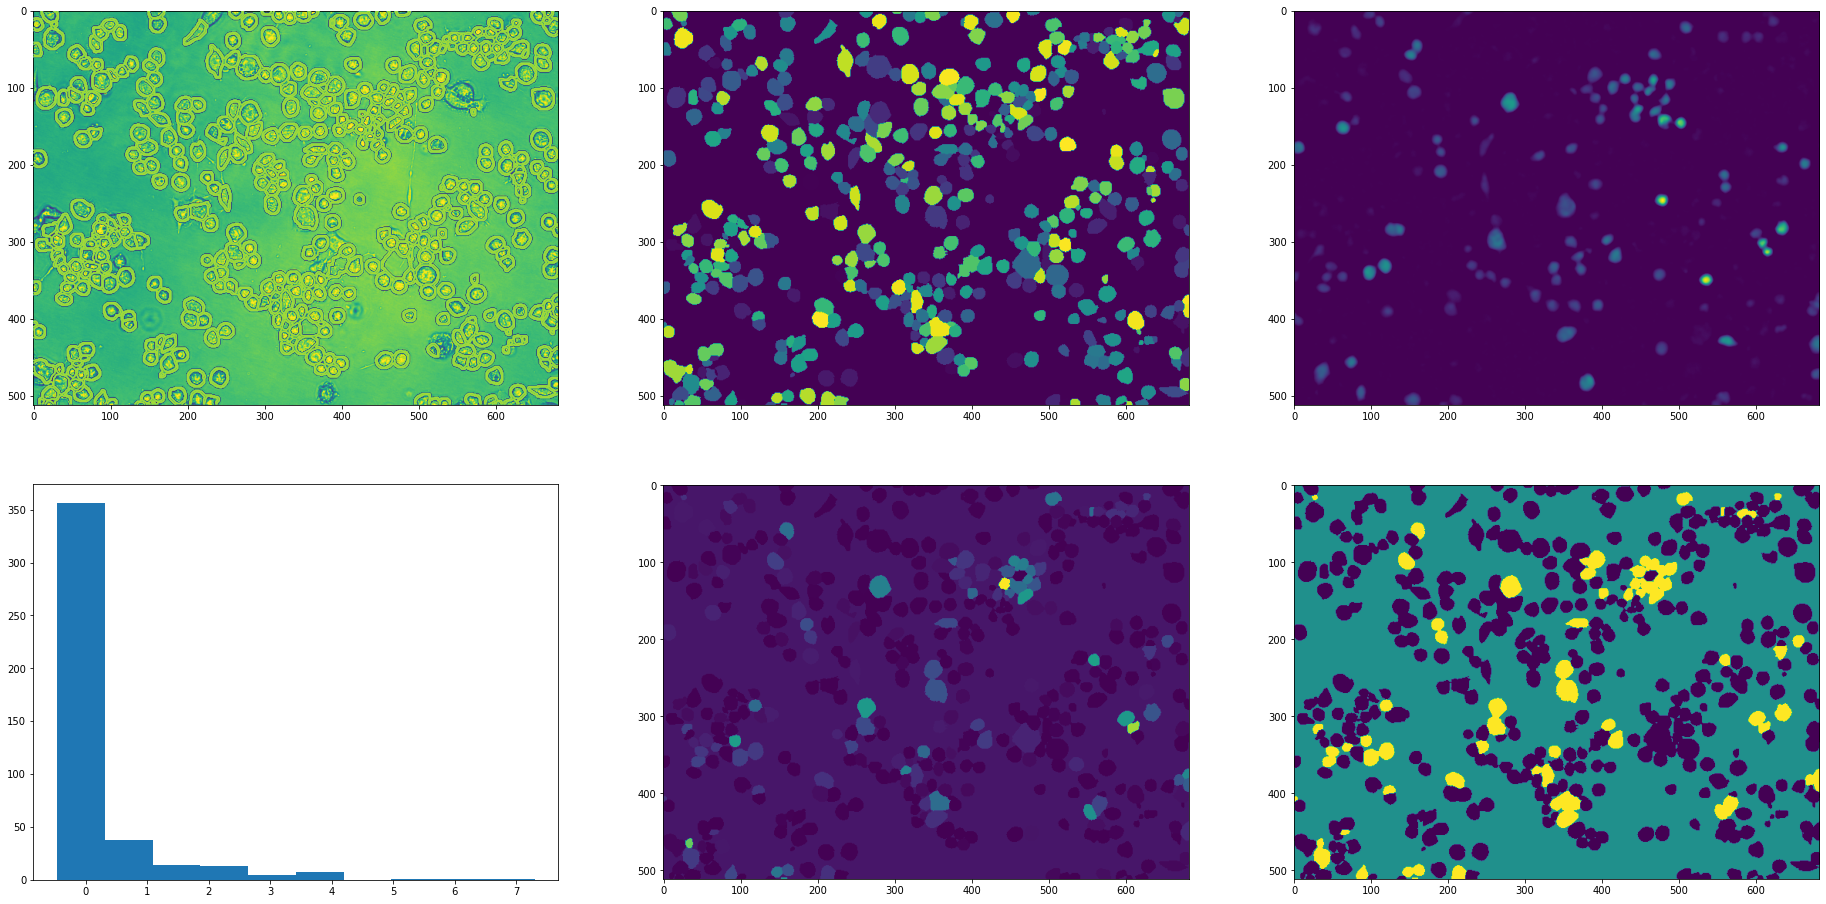

2048 1536 1 1
2048 1536 1 1


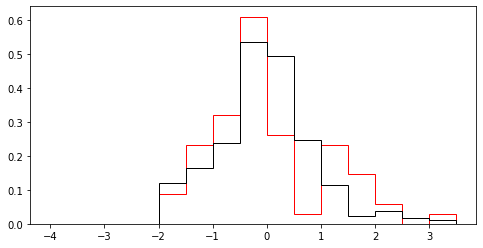

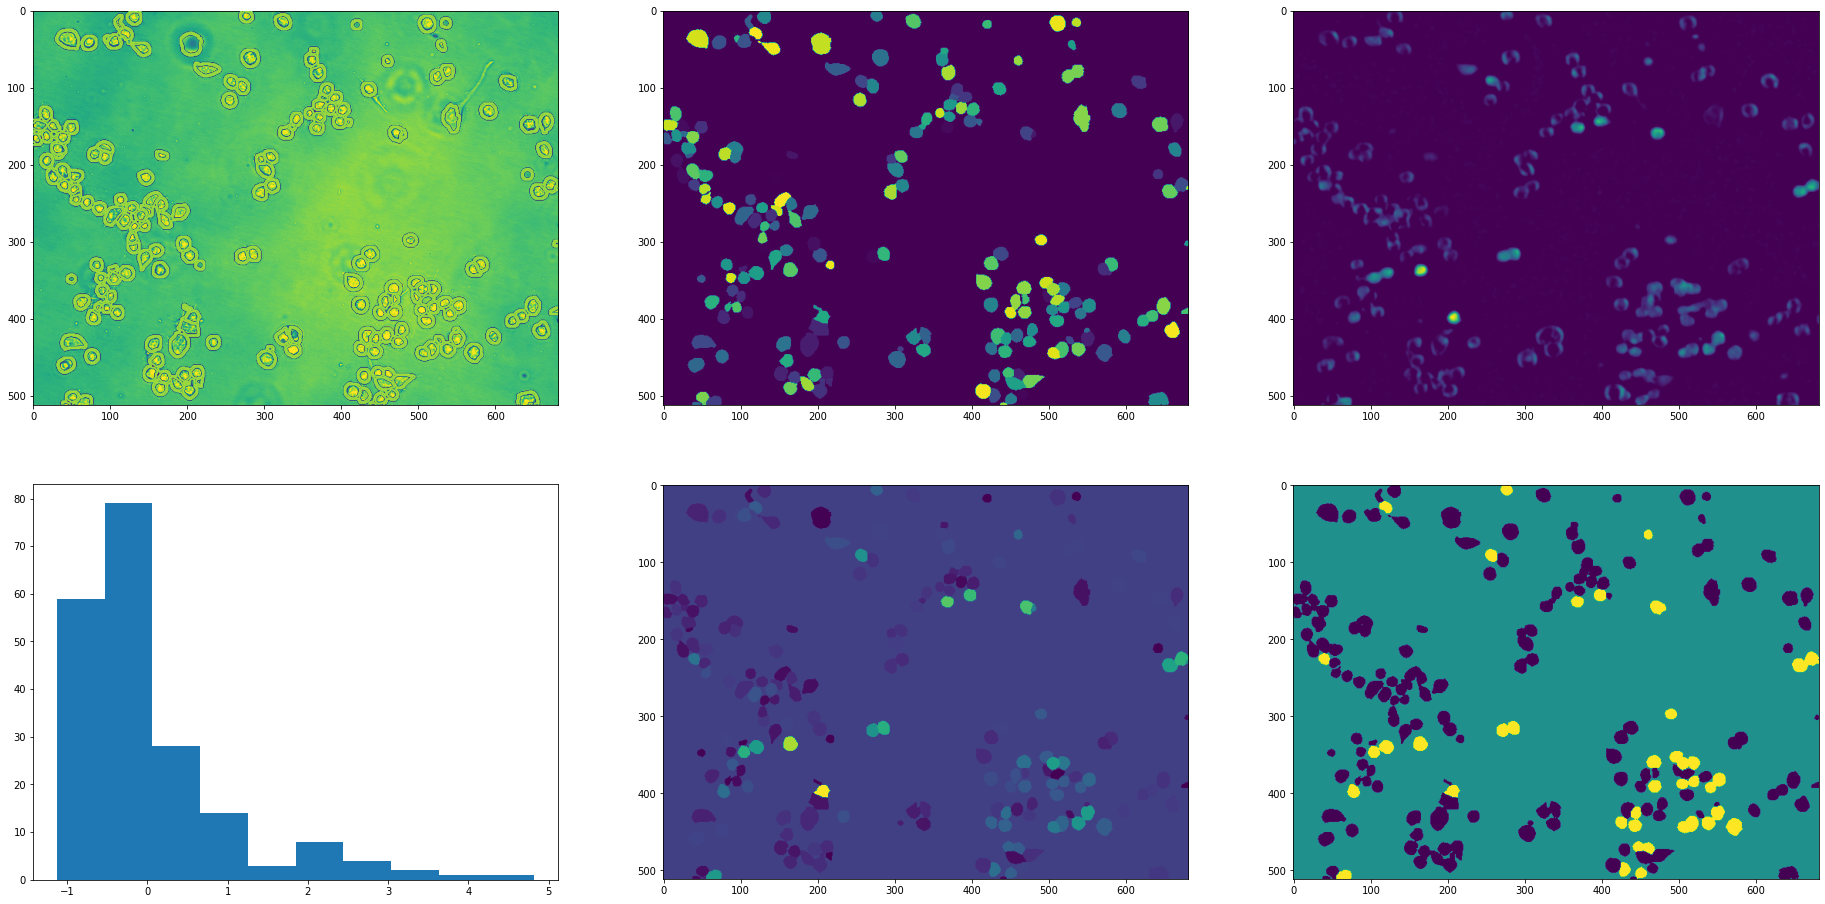

2048 1536 1 1
2048 1536 1 1


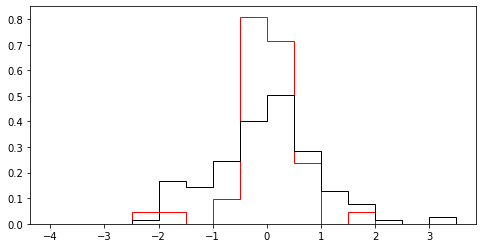

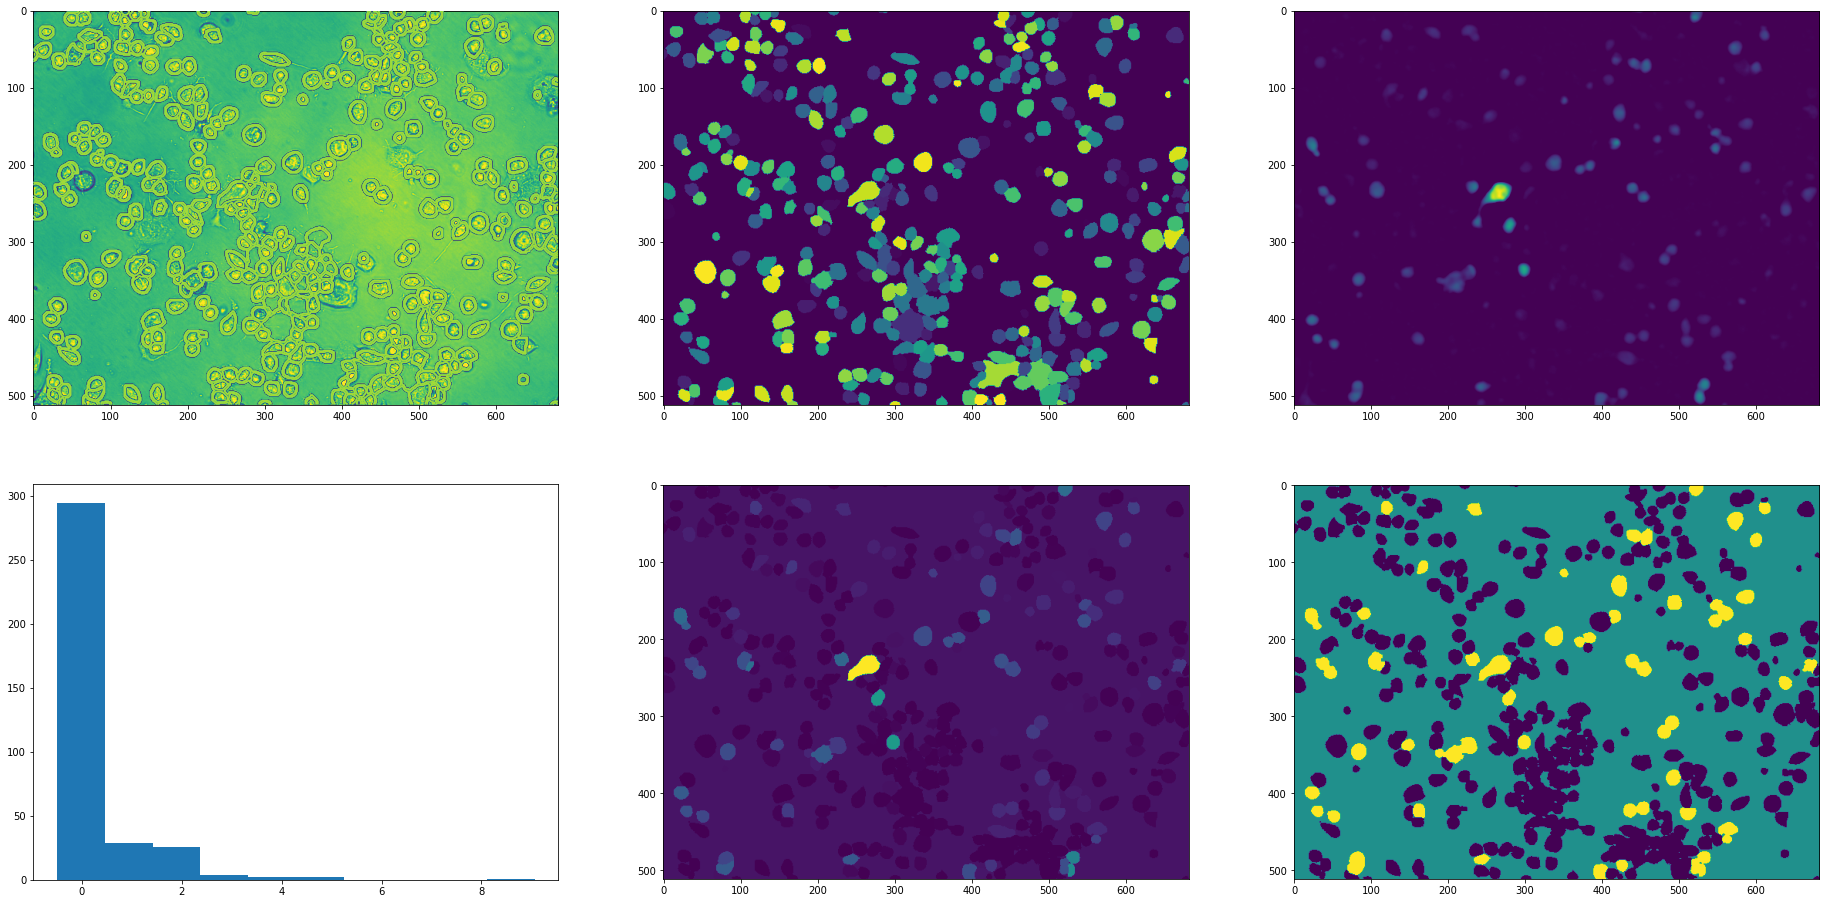

2048 1536 1 1
2048 1536 1 1


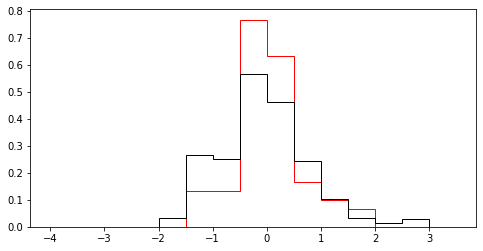

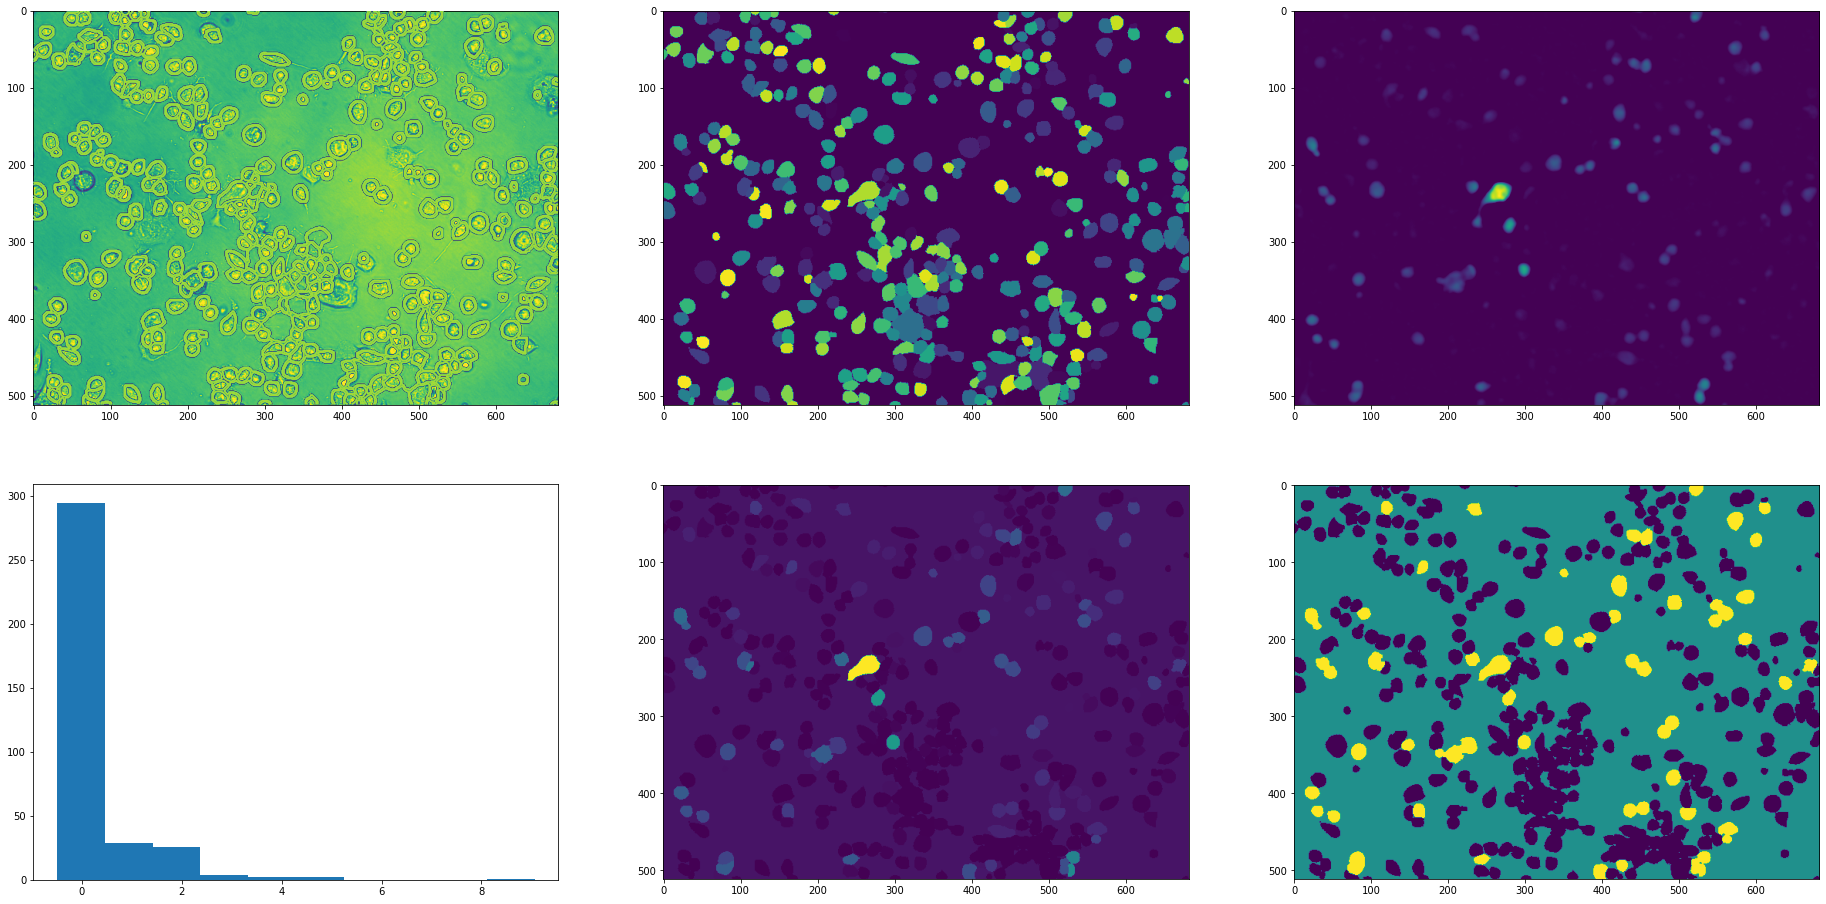

2048 1536 1 1
2048 1536 1 1


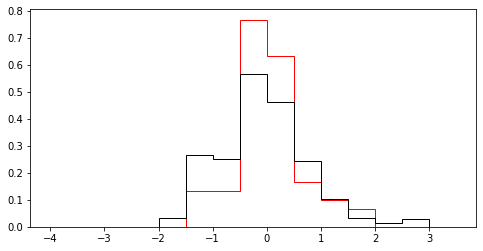

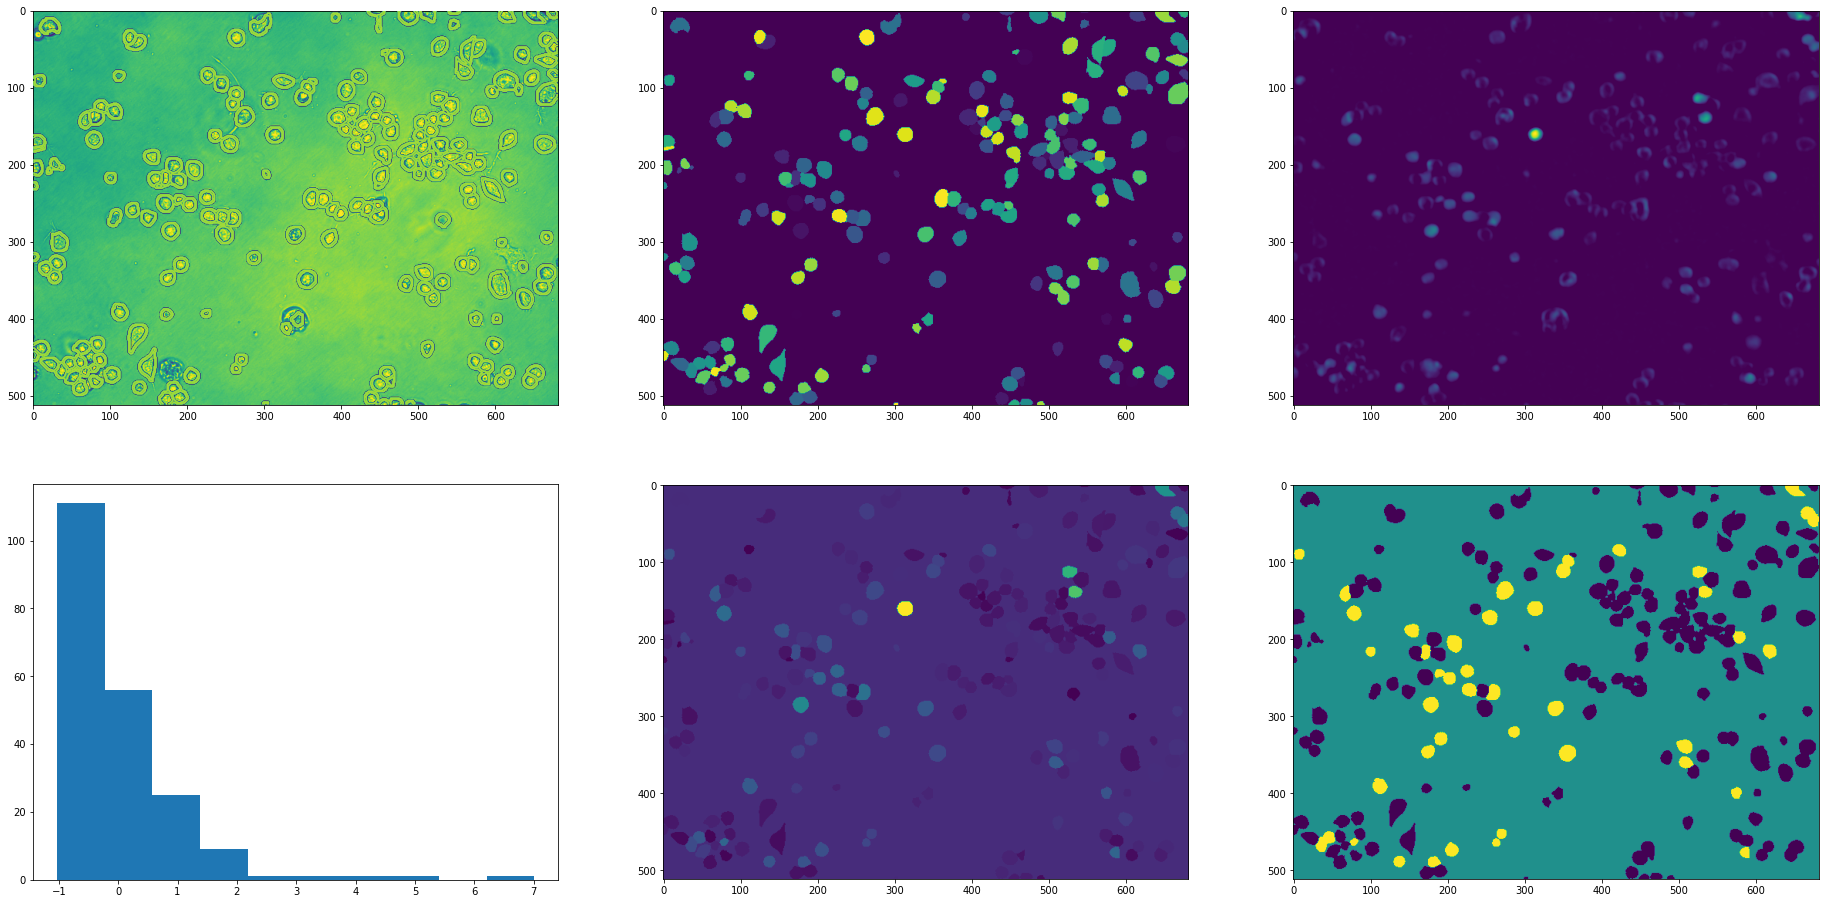

2048 1536 1 1
2048 1536 1 1


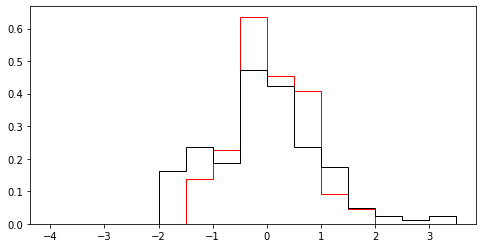

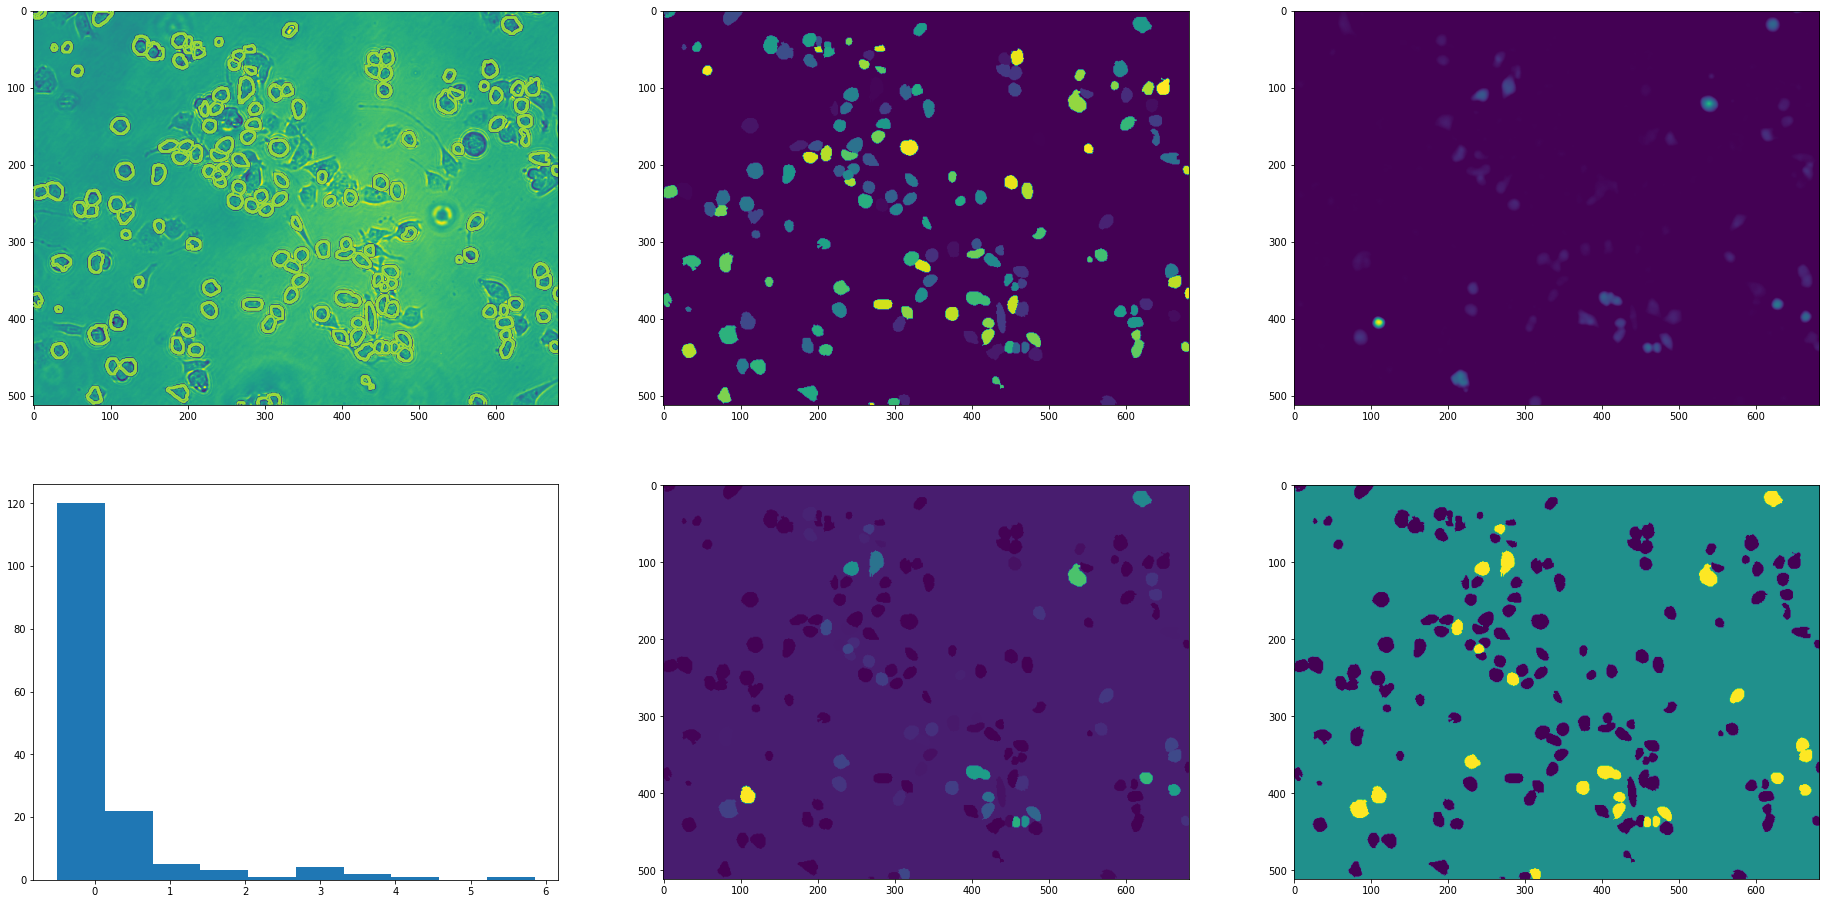

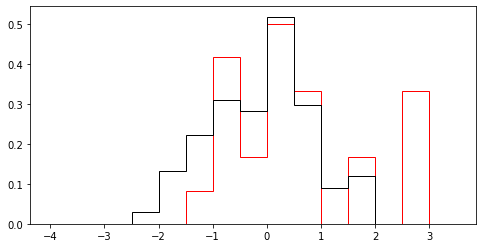

In [7]:
for fd in file_sets:
    try:
        image = read_image(fd['bright'])
    except:
        continue

    diameter = 10
    model = models.Cellpose(model_type='cyto')

    scale_f = 3

    image = skimage.transform.resize(image, (image.shape[0] // scale_f, image.shape[1] // scale_f),
                                    anti_aliasing=True)

    masks, _, _, _ = model.eval(image, diameter=diameter, channels=[0,0], do_3D=False)
    masks=masks.astype(float)
    masks = shuffle_mask(masks)
    fd['mask'] = masks



    px_areas = []
    cell_df = pd.DataFrame({'cell_id': np.arange(1,np.max(masks.flatten())+1) }).set_index('cell_id')

    image_r = read_image(fd['red'])
    image_r = skimage.transform.resize(image_r, (image_r.shape[0] // scale_f, image_r.shape[1] // scale_f),
                                    anti_aliasing=True)


    low_sigma = 5/scale_f
    high_sigma = 30/scale_f
    image_r =  skimage.filters.difference_of_gaussians(image_r, low_sigma, high_sigma=high_sigma)
    image_r[image_r<0]=0
    for ci in cell_df.index:
        cell_df.at[ci,'area'] = np.sum(np.equal(masks.flatten(),ci))
        masked_r = image_r[:,:,0]*np.equal(masks,ci)
        cell_df.at[ci,'total_red'] = np.sum(masked_r)
        cell_df.at[ci,'density_red'] = cell_df.loc[ci,'total_red']/cell_df.loc[ci,'area']

    density_map = np.zeros_like(masks)

    z_thresh = 0.5
    rd_mean = np.mean(cell_df['density_red'])
    rd_std = np.std(cell_df['density_red'])
    for ci in cell_df.index:
        cell_df.at[ci,'z_density_red'] = (cell_df.loc[ci,'density_red']-rd_mean)/rd_std
        density_map[np.where(masks==ci)] = cell_df.loc[ci,'z_density_red']
        cell_df.at[ci,'r_logical'] = cell_df.loc[ci,'z_density_red']>z_thresh

    cell_df['z_area'] = (cell_df['area'] - np.mean(cell_df['area']))/np.std(cell_df['area'])

    fig, ax = plt.subplots(2,3,figsize=[32,16])
    ax=ax.flatten()

    ax[0].imshow(image)
    ax[1].imshow(masks)
    ax[2].imshow(image_r)
    ax[3].hist(cell_df['z_density_red'])
    ax[4].imshow(density_map)
    ax[5].imshow((masks>0)*((density_map>z_thresh)-0.5))
    for a in ax:
        try: ax.colorbar()
        except: None

    edges = filters.sobel(masks)
    ax[0].contour(edges>0,zorder=999)

    plt.show()
    # display(cell_df)
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    bins = np.arange(-4,4,0.5)
    pos_hist = ax.hist(cell_df['z_area'][cell_df['r_logical']],bins=bins,density=True,color='r',histtype='step')[0]
    neg_hist = ax.hist(cell_df['z_area'][np.logical_not(cell_df['r_logical'])],bins=bins,density=True,color='k',histtype='step')[0]
    fd['df']=cell_df
    fd['pos_hist']=pos_hist
    fd['neg_hist']=neg_hist



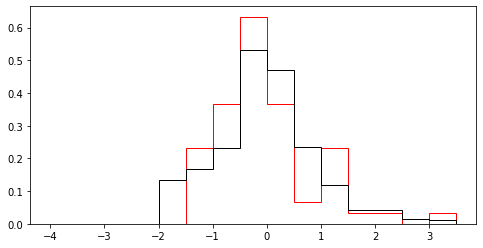

In [ ]:
pos_hist

array([ 0.,  0.,  0.,  0.,  0.,  7., 11., 19., 11.,  2.,  7.,  1.,  1.,
        0.,  1.])

In [ ]:
im_num = 2
print(file_list[im_num])
my_reader = bioformats.get_image_reader('my_image', file_list[im_num])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

images/MDGA2_08-22-22__S001_DG_40X_2XZoom_1.oir
800 800 4 6
(800, 800, 4, 6)


In [ ]:
def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    # print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image


In [ ]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 5.3 MB/s 
     |████████████████████████████████| 4.2 MB 49.7 MB/s 
     |████████████████████████████████| 31.0 MB 320 kB/s 


In [ ]:
# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
ch_names = ['target','mCherry','NeuN']




def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim

def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return masks, exp_masks


def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
    
    

    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    cell_df['Pos']=cell_df['mean_mCherry']>t
    mean_target_negative = np.mean(cell_df['raw_mean_target'][np.logical_not(cell_df['Pos'].values)])
    cell_df['target_norm'] = cell_df['raw_mean_target'] / mean_target_negative
    cell_df['target_norm_NEG'] = cell_df['target_norm'][np.logical_not(cell_df['Pos'].values)]
    cell_df['target_norm_POS'] = cell_df['target_norm'][cell_df['Pos']]

    results=pd.DataFrame(data=results,index=[0])


    return results, cell_df



def plot_sample(fov,inset_xy,pxl_per_um=800/159.1,title=None):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
    axs=axs.flatten()
    axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
    w_sig = fov['image_znorm'][2,zi,:,:]
    w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = fov['image_znorm'][1,zi,:,:]
    r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = fov['image_znorm'][0,zi,:,:]
    g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    gain = 2
    merge = w_chan + r_chan + g_chan
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    y1,y2,x1,x2, = inset_xy
    my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
    axs[0].add_patch(my_rect)

    # fig, axs = plt.subplots(1,4,figsize=(32,8))
    # axs=axs.flatten()
    axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
    axs[7].imshow(merge[x1:x2,y1:y2,:])

    for a in axs:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
    


    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)
    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[4].add_patch(small_scale_bar)
    
    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout(pad=1.1)
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')
    
    return None


def image_pipeline(image_name,chan_dim,cell_chan,z_dim,t=0):
    try:
        image = read_image(image_name)

        if image.shape[chan_dim]==4:
            image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )

        image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
        diameter = 30
        exp_dist = 5
        masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
        cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
        results,cell_df = calc_odd(cell_df,t)
        cur_image_name= os.path.basename(image_name).split('.')[0]
        potential_targets = ['MDGA2','Nell2','RNF182']
        target_name = [t for t in potential_targets if t in cur_image_name][0]
        cell_df.to_csv( cur_image_name+'Cell_Stats.csv')

        

        fov_dict = {'image_name':image_name,
                    'raw_image':image,
                    'image_r':image_r,
                    'image_znorm':image_znorm,
                    'masks':masks,
                    'exp_masks':exp_masks,
                    'cell_df':cell_df,
                    'results':results,
                    }

        inset_xy =  [150,350,0,200]
        plot_sample(fov_dict,inset_xy)
    except: print(image_name)
    
    return fov_dict


In [ ]:

# image = read_image(sub_file_list[0])
ch_dim = 3
def combine_dapi_neun( image_np, ch_dim, ch_ind=[0,3], keep_ch=3,scalar = 1 ):
    image_np_new = image_np.copy()
    new_ord = np.array([ch_dim]+[ci for ci in range(len(image_np.shape)) if ci not in [ch_dim]])
    ord_key = np.argsort(new_ord)
    image_np_new = image_np_new.transpose(new_ord)
    
    image_new_chan = image_np_new[keep_ch,:,:,:].copy()
    drop_chan = [c for c in ch_ind if c not in [keep_ch]]
    image_drop_chan =  image_np_new[drop_chan,:,:,:].copy()
    image_new_chan = image_new_chan+image_drop_chan*scalar

    image_np_new[keep_ch,:,:,:] = image_new_chan
    all_keep = np.array([c for c in range(image_np_new.shape[0]) if c not in drop_chan])
    image_np_new_dropped = image_np_new[all_keep,:,:,:]
    image_np_new_unT = image_np_new_dropped.transpose(ord_key)
    return image_np_new_unT
# combine_dapi_neun( image, 2, ch_ind=[0,3], keep_ch=3 )

  0%|          | 0/7 [00:00<?, ?it/s]
  0%|          | 0.00/25.3M [00:00<?, ?B/s]
  8%|▊         | 1.91M/25.3M [00:00<00:01, 20.1MB/s]
 26%|██▌       | 6.56M/25.3M [00:00<00:00, 34.5MB/s]
 39%|███▊      | 9.80M/25.3M [00:00<00:00, 27.7MB/s]
 49%|████▉     | 12.5M/25.3M [00:00<00:00, 23.2MB/s]
 59%|█████▊    | 14.8M/25.3M [00:00<00:00, 22.2MB/s]
 70%|███████   | 17.8M/25.3M [00:00<00:00, 24.2MB/s]
 80%|███████▉  | 20.1M/25.3M [00:00<00:00, 20.5MB/s]
 88%|████████▊ | 22.2M/25.3M [00:01<00:00, 18.5MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 17.4MB/s]

100%|██████████| 5.23k/5.23k [00:00<00:00, 9.05MB/s]


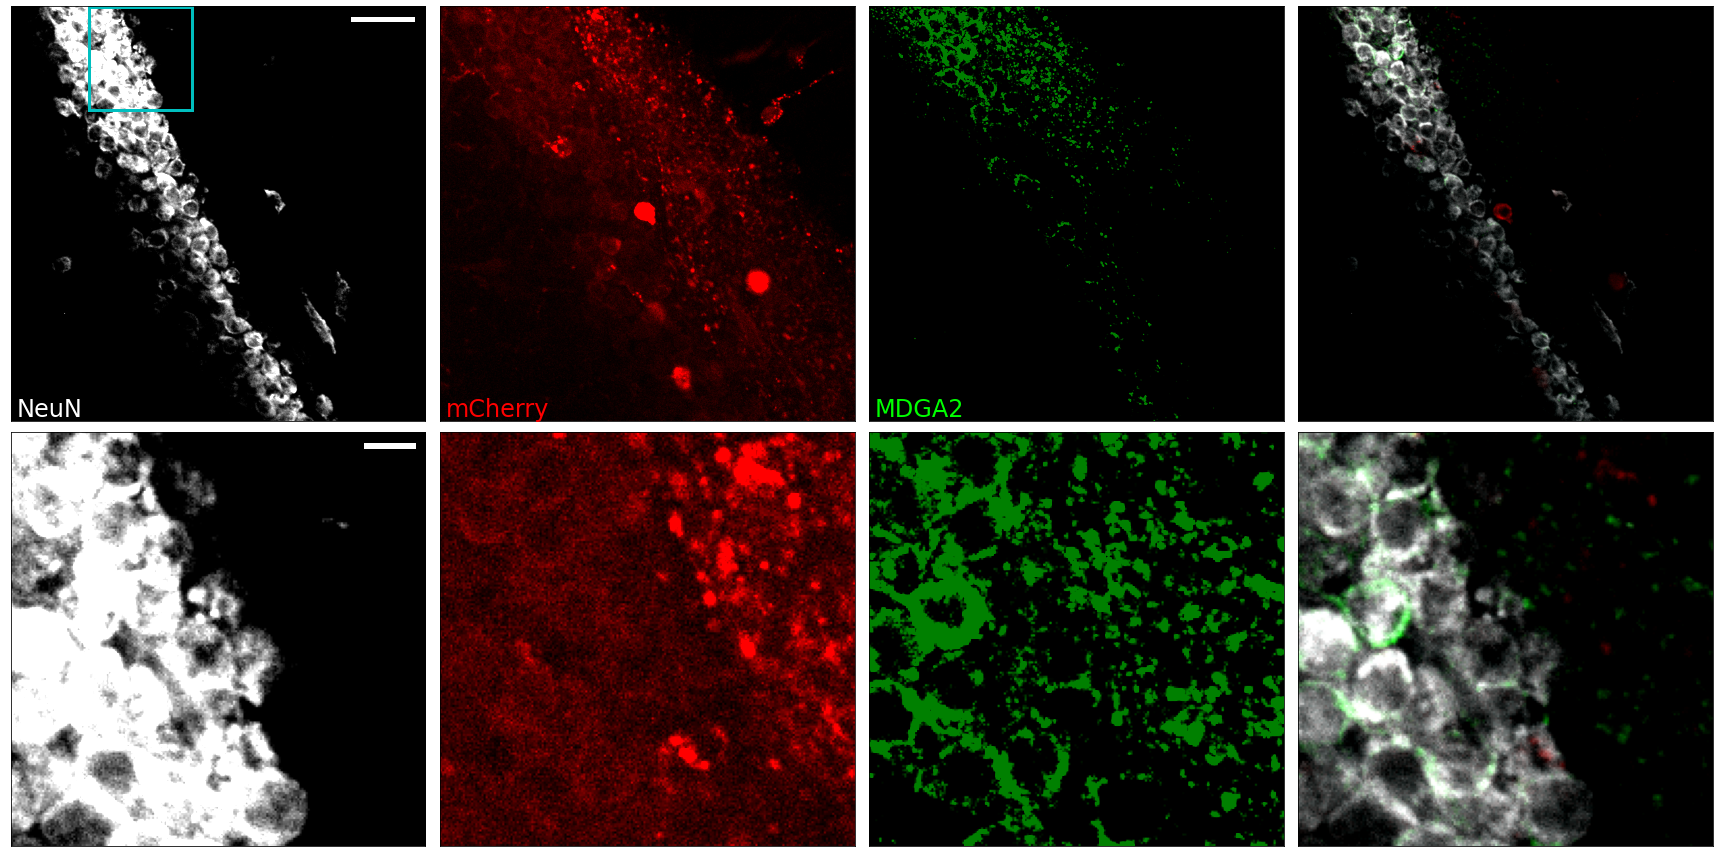

 14%|█▍        | 1/7 [04:07<24:45, 247.52s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


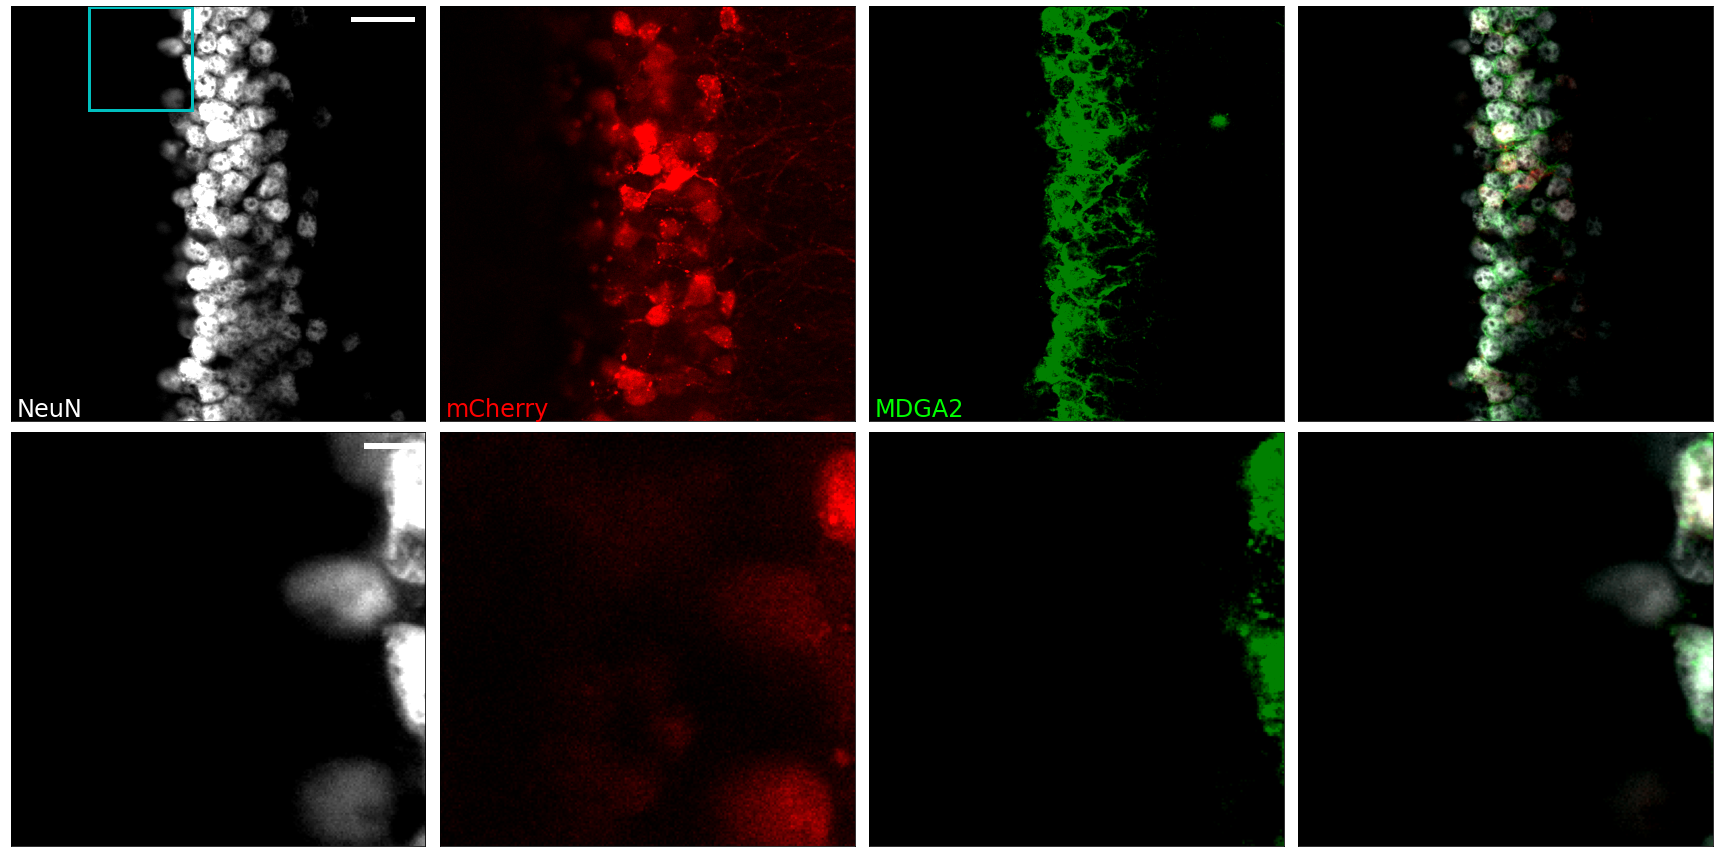

 29%|██▊       | 2/7 [09:37<24:03, 288.61s/it]

images/MDGA2_08-22-22__S001_DG_40X_2XZoom_1.oir


UnboundLocalError: ignored

In [ ]:
from tqdm import tqdm


chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
exp_dist = 5


file_index = [i for i in range(len(file_list)) if 'MDGA' in file_list[i]]
sub_file_list = [file_list[i] for i in file_index]

multi_image_results = {}
for f in tqdm( sub_file_list):

    
    
    fov_dict=image_pipeline(f,chan_dim,cell_chan,z_dim,t=1)


    multi_image_results[f]=fov_dict

X = [350,650,0,200]
insert_list = [[350,650,600,799],
               [350,450,500,700],
               [150,350,0,200],
               [150,350,0,200],
               [150,350,0,200],
               [150,350,0,200],
               [150,350,0,200]]

In [ ]:
def plot_sample(fov,inset_xy,pxl_per_um=800/159.1,title=None):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
    axs=axs.flatten()
    axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
    w_sig = fov['image_znorm'][2,zi,:,:]
    w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = fov['image_znorm'][1,zi,:,:]
    r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = fov['image_znorm'][0,zi,:,:]
    g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    gain = 2
    merge = w_chan + r_chan + g_chan
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    y1,y2,x1,x2, = inset_xy
    my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
    axs[0].add_patch(my_rect)

    # fig, axs = plt.subplots(1,4,figsize=(32,8))
    # axs=axs.flatten()
    axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
    axs[7].imshow(merge[x1:x2,y1:y2,:])

    for a in axs:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
    


    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)
    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[4].add_patch(small_scale_bar)
    
    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout() # pad=1.1
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')
    
    return None


insert_list = [[100,300,200,400],
               [350,550,400,600],
               [400,600,300,500],
            #    [150,350,0,200],
            #    [150,350,0,200],
            #    [150,350,0,200],
            #    [150,350,0,200]
               ]

# insert_dict = {key:value for (key,value) in multi_image_results.keys()}

for f_i in  range(len(multi_image_results.items())):
    fov = multi_image_results[list(multi_image_results.keys())[f_i]]
    inset_xy = insert_list[f_i]
    plot_sample(fov,inset_xy,title=fov['image_name'])
    plt.show()

In [ ]:
multi_image_results.keys()

         OR  num_RnG  num_nRnG  num_RG  num_nRG  targ_sig_nR  targ_sig_iR
0  0.638889        9       161       1       28     0.008148     0.005822
         OR  num_RnG  num_nRnG  num_RG  num_nRG  targ_sig_nR  targ_sig_iR
0  1.382324       38       116      24       53      0.05738     0.064594


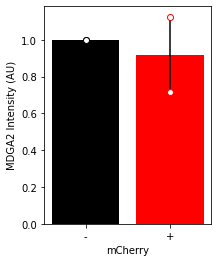

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(3,4))

targ_nR_list = []
targ_iR_list = []
for im_i in multi_image_results.keys():
    print( multi_image_results[im_i]['results'])
    targ_nR_list.append(   multi_image_results[im_i]['results']['targ_sig_nR'] )
    targ_iR_list.append(   multi_image_results[im_i]['results']['targ_sig_iR'] )

targ_iR_list = np.array(targ_iR_list)/np.array(targ_nR_list)
targ_nR_list = np.array(targ_nR_list)/np.array(targ_nR_list)


ax.bar(0,np.mean(targ_nR_list),zorder = 0,color='k',yerr=scipy.stats.sem(targ_nR_list))
ax.bar(1,np.mean(targ_iR_list),zorder = 0,color='r',yerr=scipy.stats.sem(targ_iR_list))
ax.scatter(np.zeros_like(targ_nR_list),targ_nR_list,zorder = 1,edgecolor='k',facecolor='w')
ax.scatter(np.ones_like(targ_iR_list),targ_iR_list,zorder = 1,edgecolor='r',facecolor='w')

ax.set_xticks([0,1])
ax.set_xticklabels(['-' , '+'])
ax.set_xlabel('mCherry')
ax.set_ylabel('MDGA2 Intensity (AU)')
plt.show()

In [ ]:
multi_image_results[0].keys()

In [ ]:
from google import colab

for k in multi_image_results.keys():
    multi_image_results[k]['cell_df']['Pos']=multi_image_results[k]['cell_df']['mean_mCherry']>1
    image_name = str(k).split('.')[0]
    multi_image_results[k]['cell_df'].to_csv(image_name + '_cell_stats.csv' )

for path, directories, files in os.walk('images'):
    for f in files:
        if '.csv' in f:
            print(f)
            colab.files.download( os.path.join('images',f))



MDGA2_08-22-22_DG_40X_2XZoom_1_cell_stats.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MDGA2_08-22-22_S001_DG_40X_2XZoom_1_cell_stats.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t =1

# from matplotlib.projections.polar import Axes
fov = multi_image_results[1]
zi = 9
sp_size =16
fig, axs = plt.subplots(2,2,figsize=(sp_size,sp_size))
axs =axs.flatten()
axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
axs[0].contour(fov['exp_masks'][zi,:,:],cmap='prism')


axs[1].imshow(fov['masks'][zi,:,:]>0)
axs[1].contour(fov['exp_masks'][zi,:,:],cmap='prism')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[2].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
axs[2].contour(fov['exp_masks'][zi,:,:],cmap='prism')


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[3].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmin=-1, vmax=3)
axs[3].contour(fov['exp_masks'][zi,:,:],cmap='prism')


sp_size =4
n=4
cell_df = fov['cell_df']
fig, ax = plt.subplots(1,n,figsize=(n*sp_size,sp_size))
ax=ax.flatten()
_=ax[0].hist(cell_df['mean_mCherry'])
ax[0].set_xlabel('mCherry (z)')
ax[0].set_ylabel('Cells (#)')

_=ax[1].hist(cell_df['mean_target'])
ax[1].set_xlabel('Target (z)')
ax[1].set_ylabel('Cells (#)')

ax[2].scatter(cell_df['mean_mCherry'],cell_df['mean_target'])
ax[2].set_xlabel('mCherry (z)')
ax[2].set_ylabel('Target (z)')


vals=[cell_df['raw_mean_target'][cell_df['mean_mCherry']<t],
      cell_df['raw_mean_target'][cell_df['mean_mCherry']>t]]
means = [np.mean(v) for v in vals]
errors = [np.std(v)/np.sqrt(v.size) for v in vals]


ax[3].bar([0,1],means,yerr=errors)
ax[3].set_xticks([0,1])
ax[3].set_xticklabels(['Negative','Positive'])
ax[3].set_xlabel('mCherry')
ax[3].set_ylabel('Target Intensity (AU)')
# ax[3].set_xticks()
# ax[3].title.set_text('mean_NeuN')

plt.tight_layout()
plt.show()

In [ ]:
fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
axs=axs.flatten()
axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
w_sig = fov['image_znorm'][2,zi,:,:]
w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
r_sig = fov['image_znorm'][1,zi,:,:]
r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
r_sig = r_sig/np.percentile(r_sig.flatten(),100)
r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
g_sig = fov['image_znorm'][0,zi,:,:]
g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
gain = 2
merge = w_chan + r_chan + g_chan
axs[3].imshow(merge)


axs[0].text(10,790,'NeuN',color='w',fontsize=24)
axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
axs[2].text(10,790,'MDGA2',color=[0,1,0,1],fontsize=24)
# axs[3].text(0,800,'NeuN',color='w')


y1,y2,x1,x2, = [150,350,0,200,]

my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
axs[0].add_patch(my_rect)


# fig, axs = plt.subplots(1,4,figsize=(32,8))
# axs=axs.flatten()
axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
axs[7].imshow(merge[x1:x2,y1:y2,:])

for a in axs:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
plt.tight_layout(pad=1.1)


pxl_per_um = 800/160
sb_x = 780
sb_y = 10
big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
axs[0].add_patch(big_scale_bar)
sb_x = 195
sb_y = 4
small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
axs[4].add_patch(small_scale_bar)
fig_sample.savefig('sample_MDGA2.png')






In [ ]:




inset_xy =  [150,350,0,200]
plot_sample(fov,inset_xy)

In [ ]:
image_name= os.path.basename(fov['image_name']).split('.')[0]
potential_targets = ['MDGA2','Nell2','RNF182']
target_name = [t for t in potential_targets if t in image_name][0]
print(target_name)

In [ ]:
sp_size = 8

t = 1
for zi in range(16):
    fig, axs = plt.subplots(1,2,figsize=(sp_size*2,sp_size))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[0].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    axs[0].contour(fov['exp_masks'][zi,:,:],cmap='prism')
    pos_neg_mask = fov['exp_masks'].copy()
    pos_cells = cell_df.index[cell_df['mean_mCherry']>t]
    # pos_neg_mask[pos_neg_mask==0]=np.nan
    pos_neg_mask = pos_neg_mask*-1
    for c in tqdm( pos_cells.values) :
        pos_neg_mask[pos_neg_mask==-c]=1.
    pos_neg_mask = (pos_neg_mask>0)*1.
    pos_neg_mask[fov['exp_masks']==0]=-1
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","black","red"])
    axs[1].imshow(pos_neg_mask[zi,:,:],cmap=cmap)
    axs[1].contour(fov['exp_masks'][zi,:,:],cmap='prism')


In [ ]:
print(multi_image_results[0]['results'])

In [ ]:
import numpy as np
import h5py
from google import colab
sub_f = 'data'
zip_name = sub_f+'.zip'
try: os.makedirs(sub_f)
except: None
try: hf.close()
except: None
for f in multi_image_results:
    image_name_loc = f['image_name']
    h5_name = os.path.basename(image_name_loc).split('.')[0]
    hf = h5py.File( sub_f+'/'+h5_name+'.h5', 'w')
    for k,v in f.items():
        hf.create_dataset(k, data=v)
    hf.close()
!zip -r $zip_name $sub_f
colab.files.download(zip_name)
